# Importations

In [1]:
%matplotlib notebook
import orbit_modelling_library as orbit
import math as m
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
rc('text', usetex = True)

# 3D - plot of $\chi^2$ as a function of $\alpha$ and $\lambda$

/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log10


<IPython.core.display.Javascript object>


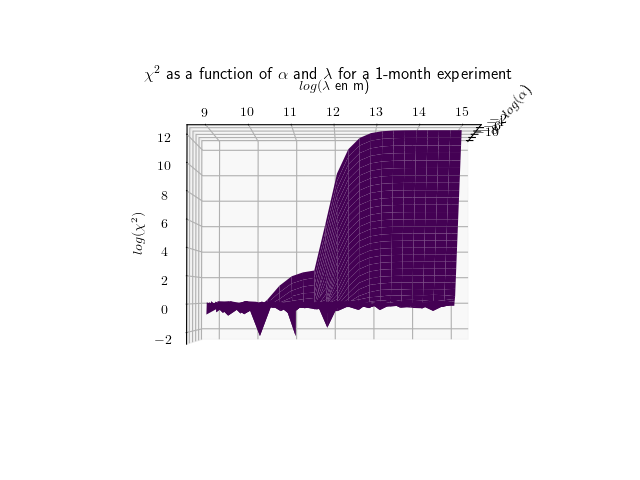

In [10]:
def chi_2(observation, model, delta_radar, delta_accelerometer, delta_initial_position, delta_initial_speed):
    if len(observation.t) != len(model.t):
        print("Error : the observation and the model are not sampled at the same times")
        return
    for i in range(len(observation.t)):
        if observation.t[i] != model.t[i]:
            print("Error : the observation and the model are not sampled at the same times")
            return
    
    T = observation.t
    time_step = T[1] - T[0]
    total_time_in_days = int((T[-1] - T[0]) / 86400)
    
    chi_2 = 0
    for k in range(total_time_in_days + 1):
        i = int(k * 86400 / time_step)
        delta = np.sqrt(delta_radar**2 + delta_initial_position**2 + ((i * time_step) * delta_initial_speed)**2 + 1/12 * i * (4 * i**2 - 1) * time_step**4 * delta_accelerometer**2)
        
        X_obs, X_mod = observation.X[i] + np.random.normal(0, delta), model.X[i]
        Y_obs, Y_mod = observation.Y[i] + np.random.normal(0, delta), model.Y[i]
        Z_obs, Z_mod = observation.Z[i] + np.random.normal(0, delta), model.Z[i]

        chi_2 += ((X_obs - X_mod)**2 + (Y_obs - Y_mod)**2 + (Z_obs - Z_mod)**2) / (2 * delta**2)
    return chi_2

def grid_analysis(time_isot_start, time_isot_end, n_points_t, target_files,
         lambda_start, lambda_end, n_points_lambda, 
         alpha_start, alpha_end, n_points_alpha, 
         delta_radar, delta_accelerometer, delta_initial_position, delta_initial_speed, 
         Bodies = [i + 1 for i in range(10)], type_model = "Newton", alpha_model = 10**(-4), lambdaa_model = 10**12,
         radiation = False, solar_wind = False, 
         reflectivity_sat = 0.5, radius_sat = 0.63, mass_sat = 100, plasma_speed = 450000):
    
    target_file = target_files + "_model"
    model = orbit.Orbit_model(time_isot_start, time_isot_end, n_points_t, target_file, Bodies, type_model, alpha_model, lambdaa_model, radiation, solar_wind, reflectivity_sat, radius_sat, mass_sat, plasma_speed)
    model.load()
    
    Lambda1 = [10**(9) * (10**(11) / 10**(9))**(i / (8 - 1)) for i in range(8)] # a modifier
    Lambda2 = [10**(11) * (10**(15) / 10**(11))**(i / (16 - 1)) for i in range(16)] # a modifier
    Lambda = Lambda1 + Lambda2 # a modifer
    Alpha = [alpha_start * (alpha_end / alpha_start)**(i / (n_points_alpha - 1)) for i in range(n_points_alpha)]
    Z = [[0 for j in range(len(Alpha))] for i in range(len(Lambda))]
    for i in range(len(Lambda)):
        for j in range(len(Alpha)):
            lambdaa = Lambda[i]
            alpha = Alpha[j]
            
            target_file = target_files + "_lambda_=_" + str(lambdaa) + "_alpha_=_" + str(alpha)
            observation = orbit.Orbit_model(time_isot_start, time_isot_end, n_points_t, target_file, Bodies, "Yukawa", alpha, lambdaa, radiation, solar_wind, reflectivity_sat, radius_sat, mass_sat, plasma_speed)
            observation.load()
            
            sum_chi_2 = 0
            for k in range(500): # greatly lowers the variations on chi_2
                sum_chi_2 += chi_2(observation, model, delta_radar, delta_accelerometer, delta_initial_position, delta_initial_speed)
            average_chi_2 = sum_chi_2 / 500
            
            Z[i][j] = average_chi_2
    
    Z_model = chi_2(model, model, delta_radar, delta_accelerometer, delta_initial_position, delta_initial_speed)
    
    Z = np.asarray(Z)
    m = min(np.amin(Z), Z_model)
    Z -= m
    
    E = []
    for i in range(len(Lambda)):
        for j in range(len(Alpha)):
            if Z[i][j] > 6.7:
                E.append((Lambda[i], Alpha[j]))
    
    Z = np.log10(Z) # meilleur affichage 3D
    
    return(Z, m, E)

def drawing(lambda_start, lambda_end, n_points_lambda, 
            alpha_start, alpha_end, n_points_alpha, 
            grid_alpha_lambda):
    
    Lambda1 = [10**(9) * (10**(11) / 10**(9))**(i / (8 - 1)) for i in range(8)] # a modifier
    Lambda2 = [10**(11) * (10**(15) / 10**(11))**(i / (16 - 1)) for i in range(16)] # a modifier
    Lambda = Lambda1 + Lambda2 # a modifer
    Alpha = [alpha_start * (alpha_end / alpha_start)**(i / (n_points_alpha - 1)) for i in range(n_points_alpha)]
    X = np.log10(Lambda)
    Y = np.log10(Alpha)
    X, Y = np.meshgrid(Y, X)
    Z = np.asarray(grid_alpha_lambda)

    fig = plt.figure(1)
    ax = fig.gca(projection = '3d')
    ax.set_title("$\chi^2$ as a function of $\\alpha$ and $\lambda$ for a 1-month experiment")
    #ax.set_xlim(10, 20)
    #ax.set_ylim(-8, -7) # beware
    ax.set_xlabel("$log(\\alpha$)")
    ax.set_ylabel("$log(\lambda$ en m)")
    ax.set_zlabel("$log(\chi^2)$")
    ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = 'viridis', edgecolor = 'none')
    plt.show()

delta_radar = 1
delta_accelerometer = 10**(-12)
delta_initial_position = delta_radar
delta_initial_speed = 0

Z, m, E = grid_analysis("2050-01-01T00:00:00", "2050-02-01T00:00:00", 10**4, "Orbits_1_month", 
         10**(9), 10**(15), 24, 
         10**(-10), 10**(-1), 36, 
         delta_radar, delta_accelerometer, delta_initial_position, delta_initial_speed)

drawing(10**(9), 10**(15), 24, 
         10**(-10), 10**(-1), 36, 
        Z)

<IPython.core.display.Javascript object>


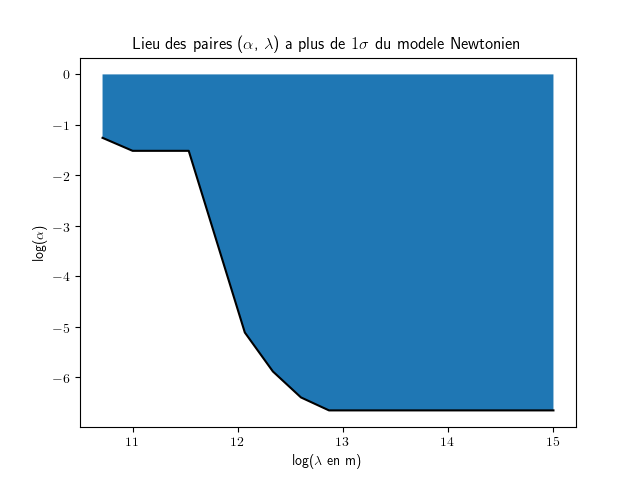

In [11]:
Lambda1 = [10**(9) * (10**(11) / 10**(9))**(i / (8 - 1)) for i in range(8)] # a modifier
Lambda2 = [10**(11) * (10**(15) / 10**(11))**(i / (16 - 1)) for i in range(16)] # a modifier
Lambda = Lambda1 + Lambda2 # a modifer
Alpha = [10**(-10)* (10**(-1) / 10**(-10))**(i / (36 - 1)) for i in range(36)]

X = []
Y = []
for i in range(24):
    lambdaa = Lambda[i]
    
    alpha_min = 1
    for e in E:
        l, a = e
        if ((l == lambdaa) and (a < alpha_min)):
            alpha_min = a
    
    if (alpha_min < 1):
        X.append(np.log10(lambdaa))
        Y.append(np.log10(alpha_min))

plt.figure(2)
plt.title("Lieu des paires ($\\alpha$, $\lambda$) a plus de $1\sigma$ du modele Newtonien")
plt.xlabel("log($\lambda$ en m)")
plt.ylabel("log($\\alpha$)")
plt.plot(X, Y, 'k')
plt.fill_between(X, 0, Y)
plt.show()